In [1]:
from scipy.stats import norm
import numpy as np
def EI(Y, y_min):
    std = np.std(Y)
    mu = np.mean(Y)
    diff = y_min-mu
    if std == 0:
        return(0, 0)
    u = diff/std
    EI = []
    for i in range (len(Y)):

        ei = diff*norm.cdf(u)+std*norm.pdf(u)
        EI.append(ei)
    return(np.argmax(EI), np.max(EI))

In [2]:
def divivide_plan(y_sample1,y_sample2, theta, n):
    Y1 = list()
    Y2 = list()
    IND = list()
    for i in range(n-1):
        y1 = []
        y2 = []
        ind = []
        for j in range (len(y_sample1)):
            
            if np.tan((i+1)*theta) * y_sample1[j][0] >= y_sample2[j][0] and np.tan(i*theta) * y_sample1[j][0] <= y_sample2[j][0]:
                y1.append(y_sample1[j][0])
                y2.append(y_sample2[j][0])
                ind.append(j)
            if i+1 == n and np.tan(i*theta) * y_sample1[j][0] <= y_sample2[j][0]:
                y1.append(y_sample1[j][0])
                y2.append(y_sample2[j][0])
                ind.append(j)
        Y1.append(y1)
        Y2.append(y1)
        IND.append(ind)
    return(Y1, Y2, IND)  

In [3]:
import openturns as ot
import numpy as np
import subprocess
class MyModel2:
    def __init__(self, noms_params, Re, penalty, epaiss, rho):
        self.noms_params = noms_params
        self.Re = Re
        self.penalty = penalty
        self.epaiss = epaiss
        self.rho = rho

    def write_params(self, params):
        list_params = [(self.noms_params[i], params[i]) for i in range(len(params))]
        filename = 'C:/Users/TOUGERON/Documents/PRO/SMECA/ModeleTable_OCTAVE/Param_test.txt'
        with open(filename, 'w') as file:
            for param, value in list_params:
                file.write(f"{param} {value}\n")
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_para_compo.txt'
        with open(file_path, 'a') as file:
            file.write('-------\n')
            for param, value in list_params:
                
                file.write(f"{param} {value}\n")
    def read_defo(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/deformations'
        defo_values = []
        start_reading = False
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if "EPXX" in line:
                    start_reading = True
            
                if start_reading:

                    if '=====>' in line:
                        break
                    try:
                        defo = line.split("|")
                        if len(defo) <=5:
                            break
                        else:
                            defo = defo[4]
                            defo = float(defo)
                            defo_values.append(defo)
                    except ValueError:
                        continue
        return(defo_values)
        
    def read_output(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/res_const.txt'
        vm_values = []
        start_reading = False
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if "VMIS" in line:
                    start_reading = True
            
                if start_reading:

                    if '=====>' in line:
                        break
                    try:
                        vm = line.split("|")
                        if len(vm) <=5:
                            break
                        else:
                            vm = vm[4]
                            vm = float(vm)
                            vm_values.append(vm)
                    except ValueError:
                        continue
        return(vm_values)

    def launch_calcul(self):
        l1 = subprocess.check_output('wsl -d smeca /opt/sm/bin/as_run /mnt/c/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/export')
        return(l1)        

    def launch_mesh(self):
        l1 = subprocess.check_output('wsl -d smeca /opt/sm/bin/salome_meca shell python /mnt/c/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/script_compo2.py')
        return(l1)

    def read_flamb(self):
        with open('C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/resu_flamb', 'r') as file:
            lines = file.readlines()

        # Initialiser une liste pour stocker les valeurs de CHAR_CRIT
        char_crit_values = []

        # Parcourir chaque ligne et extraire la valeur de CHAR_CRIT
        for line in lines:
            # Supprimer les espaces en début et fin de ligne
            line = line.strip()
            if "=====>" in line:
                break
            # Vérifier si la ligne contient une valeur CHAR_CRIT valide
            if line and not any(c.isalpha() for c in line.split()[1:]):
                # Extraire la valeur de CHAR_CRIT (colonne 2)
                try:
                    char_crit = line.split()[1].replace('D', 'E')  # Remplacer D par E pour notation scientifique
                    char_crit = float(char_crit)  # Convertir en float
                    char_crit_values.append(char_crit)
                except (IndexError, ValueError):
                # Ignorer les lignes qui ne correspondent pas au format attendu
                    continue

        char_crit_array = np.array(char_crit_values)
        return(char_crit_array)

    def read_mass(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/masse.txt'
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        for line in lines:
            if line.startswith("Table"):
                columns = line.split()
                try:
                    mass = float(columns[2])
                       
                    return mass
                except (IndexError, ValueError) as e:
                    raise ValueError("Erreur lors de l'extraction de la masse : {}".format(e))
         
        raise ValueError("La ligne contenant la masse n'a pas été trouvée.")
    def insert_line_before_clt140(self, params):
        filename = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/Stage_1.comm'
        # Lire le contenu du fichier
        with open(filename, 'r') as file:
            lines = file.readlines()
    
        # Trouver l'index de la ligne contenant 'clt140'
        for i, line in enumerate(lines):
            if 'a = ' in line:
                index = i
                break    
        lines[index] =  f'a = {params[len(params)-2]}\n'
        for i, line in enumerate(lines):
            if 'N = ' in line:
                index = i
                break    
        lines[index] =  f'N = {params[len(params)-1]}\n'    
        # Écrire le contenu modifié dans le fichier
        with open(filename, 'w') as file:
            file.writelines(lines)
    
    def remove_section(self):
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/Stage_1.comm'
        with open(file_path, 'r') as file:
            lines = file.readlines()
        start_keyword = 'clt140 = '
        end_keyword = 'fieldmat = '
        new_lines = []
        inside_section = False
        for line in lines:
            if start_keyword in line:
                new_lines.append(line)
                inside_section = True
            if end_keyword in line and inside_section == True:
                inside_section = False
                new_lines.append(line)
                continue
            if inside_section == False:
                new_lines.append(line)
        with open(file_path, 'w') as file:
            file.writelines(new_lines)
    
    def for_couches(self, params):
        filename = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/Table_composite_axe_Files/RunCase_5/Result-Stage_1/Stage_1.comm'

        with open(filename, 'r' ) as file:
            lines = file.readlines()
        b = True
        to_bewritten = f'''_F(EPAIS=5.0, 
                                    MATER=wood, 
                                    ORIENTATION={params[-2]}),'''
        for i in range (int(params[len(params)-1]-1)):
            if b :
                to_bewritten = to_bewritten + '\n'
                to_bewritten = to_bewritten + f'''                                 _F(EPAIS=5.0, 
                                    MATER=wood, 
                                    ORIENTATION={params[-2]}),'''
                b = False
            else : 
                to_bewritten = to_bewritten + '\n'
                to_bewritten = to_bewritten + '''                                 _F(EPAIS=5.0, 
                                    MATER=wood, 
                                    ORIENTATION=0.0),'''
                b = True
        for k, line in enumerate(lines):
            if 'clt140 = ' in line:
                index = k
                break 
        lines[index] = f'''clt140 = DEFI_COMPOSITE(identifier=\'7:1\', 
                        COUCHE= ({to_bewritten}))\n'''
        with open(filename, 'w') as file:
                file.writelines(lines)
        
    def perform_calculations(self, params):
        self.insert_line_before_clt140(params)
        self.write_params(params)
        self.remove_section()
        self.for_couches(params)
        self.launch_mesh()
        self.launch_calcul()
 
        self.results_vm = self.read_output()
        self.results_flamb = self.read_flamb()
        self.mass = self.read_mass()
        self.defo = self.read_defo()   

    def objective(self, params):
        self.perform_calculations(params)
        alpha = min(np.abs(self.defo))
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_defo_compo.txt'
        with open(file_path, 'a') as file:
            file.write('-------\n')
            file.write(f"{alpha}\n")
        file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_obj_compo.txt'
        with open(file_path, 'a') as file:
            file.write('-------\n')
            file.write(f"{self.mass}\n")
        return self.mass,alpha
    
    def constr_flamb(self, params):
        self.perform_calculations(params)
        coeff = np.abs(self.results_flamb)

        return(min(coeff)-1)
    
    def constr_vm(self, params):
        self.perform_calculations(params)
        coeff = np.abs(self.results_vm)
        return(-max(coeff)+Re)

In [4]:
def clear_file(file_path):
    with open(file_path, 'w') as file:
        # Ouvrir en mode écriture 'w' efface le contenu du fichier
        pass 

def trace(file_path):
    values = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line and line!='-------' :
                if len(values) == 0:
                    values.append(float(line))
                elif float(line)!=values[len(values)-1]: 
                    values.append(float(line))
    return values


In [5]:
import numpy as np
import openturns as ot

# Créer une instance du modèle
noms_params = ['L1', 'L2', 'H', 'P', 'a', 'N']
Re = 80
penalty = 10e6
epaiss = 20
rho = 7800

modele = MyModel2(noms_params, Re, penalty, epaiss, rho)

# Définir la fonction objectif pour OpenTURNS
def objective_function1(params):
    return [modele.objective(params)[0]]

def objective_function2(params):
    return [modele.objective(params)[1]]

def constraint_flamb(params):
    return([modele.constr_flamb(params)])

def constraint_vm(params):
    return([modele.constr_vm(params)])

obj1 = ot.PythonFunction(len(noms_params), 1, objective_function1)
obj2 = ot.PythonFunction(len(noms_params), 1, objective_function2)
constraint1 = ot.PythonFunction(len(noms_params), 1, constraint_flamb)
constraint2 = ot.PythonFunction(len(noms_params), 1, constraint_vm)


integer_values = [[i] for i in range (1,20)]
discrete_values = ot.Sample(integer_values)
factory = ot.UserDefinedFactory()
distribution = factory.build(discrete_values)
uniform = ot.ComposedDistribution([ot.Uniform(500, 3000), ot.Uniform(300, 2000), ot.Uniform(400, 1500), ot.Uniform(25,100), ot.Uniform(0,90), distribution])
x_train = uniform.getSample(10)

start = obj1.getCallsNumber() + obj2.getCallsNumber()
y_train1 = obj1(x_train)
y_train2 = obj2(x_train)
end = obj1.getCallsNumber() + obj2.getCallsNumber()

N_ite = end-start

N_appels_max = 90
dimension = 6

FP1 = []
FP2 = []
file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_para_compo.txt'
clear_file(file_path)
file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_obj_compo.txt'
clear_file(file_path)
file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_defo_compo.txt'
clear_file(file_path)


while N_ite <= N_appels_max:
    start = obj1.getCallsNumber() + obj2.getCallsNumber()
    
    basis = ot.ConstantBasisFactory(dimension).build()
    # basis = ot.LinearBasisFactory(dimension).build()
    basis = ot.QuadraticBasisFactory(dimension).build()
    covarianceModel = ot.MaternModel( [1000, 300, 400, 20, 90,10], 1.5)
    algo = ot.KrigingAlgorithm(x_train, y_train1, covarianceModel,  basis)
    algo.run()
    result1 = algo.getResult()
    krigeageMM1 = result1.getMetaModel()
    
    basis = ot.ConstantBasisFactory(dimension).build()
    # basis = ot.LinearBasisFactory(dimension).build()
    # basis = ot.QuadraticBasisFactory(dimension).build()
    covarianceModel = ot.MaternModel([1000, 300, 400, 20, 90, 10] , 1.5)
    algo = ot.KrigingAlgorithm(x_train, y_train2, covarianceModel,  basis)
    algo.run()
    result2 = algo.getResult()
    krigeageMM2 = result2.getMetaModel()
    
    functions = list()
    functions.append(krigeageMM1)
    functions.append(krigeageMM2)
    model = ot.AggregatedFunction(functions)
    problem = ot.OptimizationProblem(model)
    bounds = ot.Interval([500,300,400,25,0, 1],[3000, 2000, 1500, 100, 90,20])
    problem.setBounds(bounds)
    problem.setVariablesType([ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.CONTINUOUS,ot.OptimizationProblemImplementation.INTEGER])
    # problem.setInequalityConstraint(constraint1)
    # problem.setInequalityConstraint(constraint2)
    
    dim = 6
    integer_values = [[i] for i in range (1,20)]
    discrete_values = ot.Sample(integer_values)
    factory = ot.UserDefinedFactory()
    distribution = factory.build(discrete_values)
    uniform = ot.ComposedDistribution([ot.Uniform(500, 3000), ot.Uniform(300, 2000), ot.Uniform(400, 1500), ot.Uniform(25,100), ot.Uniform(0,90), distribution])
    
    ot.RandomGenerator.SetSeed(0)

    init_pop = uniform.getSample(8)

    # Algo NSGAII
    algo = ot.Pagmo(problem, 'nsga2', init_pop) 

    algo.setMaximumIterationNumber(5) 

    algo.run() 

    result = algo.getResult() 

    final_pop_x = result.getFinalPoints() 

    final_pop_y = result.getFinalValues()

    front0 = result.getParetoFrontsIndices()[0] 

    front0_x = final_pop_x.select(front0) 

    front0_y = final_pop_y.select(front0)

    # Sélection des points
    y_min1 = np.min(y_train1)
    y_min2 = np.min(y_train2)
    n = 3
    Y1, Y2, IND= divivide_plan(front0_y[:,0],front0_y[:,1], np.pi/n, n)

    for i in range (len(Y1)):
        if len(Y1[i])==0 or len(Y2[i])==0:
            None
        else :    
            arg1, ei1 = EI(Y1[i], y_min1)
            arg2, ei2 = EI(Y2[i], y_min2)
            V11 = obj1(front0_x[IND[i]][arg2])
            V21 = obj2(front0_x[IND[i]][arg2])
            V12 = obj1(front0_x[IND[i]][arg1])
            V22 = obj2(front0_x[IND[i]][arg1])
            if ei2>ei1:
                y_train1 = np.concatenate ((y_train1, np.array([V11])))
                y_train2 = np.concatenate((y_train2, np.array([V21])))
                x_train = np.concatenate((x_train, np.array([front0_x[IND[i]][arg2]])))
                FP1.append(V11)
                FP2.append(V21)
            else : 
                y_train1 = np.concatenate ((y_train1, np.array([V12])))
                y_train2 = np.concatenate((y_train2, np.array([V22])))
                x_train = np.concatenate((x_train, np.array([front0_x[IND[i]][arg1]])))
                FP1.append(V12)
                FP2.append(V22)
    end = obj1.getCallsNumber() + obj2.getCallsNumber()
    N_ite+=end-start
    print(N_ite)

KeyboardInterrupt: 

RuntimeError: InternalException : Python exception: KeyboardInterrupt: 

In [6]:
obj1([1000, 600, 400, 50, 50, 5])

class=Point name=Unnamed dimension=1 values=[2.66e+10]

In [21]:
Mass_tab = trace('C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_obj_compo.txt')

Text(0, 0.5, "Valeur de l'objectif")

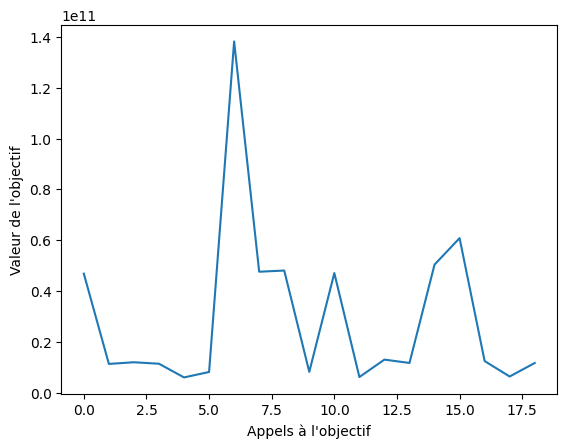

In [22]:
import matplotlib.pyplot as plt 
plt.plot(Mass_tab)
plt.xlabel('Appels à l\'objectif')
plt.ylabel('Valeur de l\'objectif')

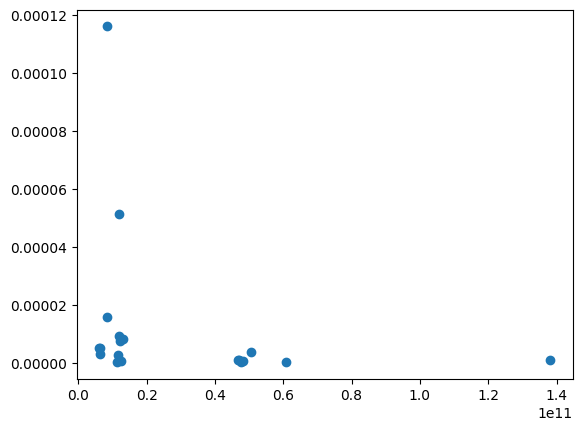

In [23]:
plt.scatter(FP1, FP2)

Text(0, 0.5, 'Valeur')

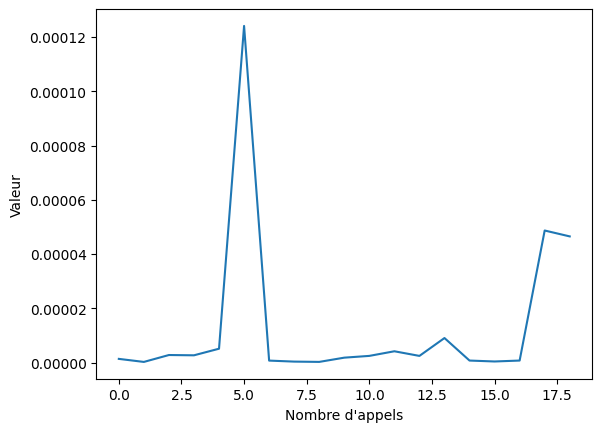

In [26]:
import matplotlib.pyplot as plt

defo_tab = trace('C:/Users/TOUGERON/Documents/PRO/SMECA/Modele_def/compo/evol_defo_compo.txt')

defo_tab = [defo_tab[4*i] for i in range (len(defo_tab)//4)]
plt.plot(defo_tab)
plt.xlabel('Nombre d\'appels')
plt.ylabel('Valeur')

In [29]:
x_train

array([[2.15927693e+03, 5.51404724e+02, 7.78631531e+02, 3.81740020e+01,
        2.58199072e+01, 3.00000000e+00],
       [1.83376840e+03, 8.93504743e+02, 1.17745935e+03, 7.32292909e+01,
        2.16980163e+01, 4.00000000e+00],
       [2.45466361e+03, 5.85935107e+02, 9.86677562e+02, 9.58332408e+01,
        2.65924567e+01, 3.00000000e+00],
       [2.16415282e+03, 7.94659384e+02, 1.43054387e+03, 4.81572646e+01,
        5.80253074e+01, 1.50000000e+01],
       [1.05819797e+03, 1.69941329e+03, 1.32679454e+03, 3.98749152e+01,
        4.42722102e+01, 2.00000000e+00],
       [2.36802797e+03, 1.05667586e+03, 7.82815880e+02, 3.48710696e+01,
        2.97949043e+01, 4.00000000e+00],
       [5.07295143e+02, 1.17716284e+03, 1.18171480e+03, 8.17299820e+01,
        5.55394152e+01, 2.00000000e+00],
       [1.53173990e+03, 7.05733083e+02, 9.40914668e+02, 5.27513534e+01,
        1.55605959e+01, 1.40000000e+01],
       [5.39503122e+02, 1.73695892e+03, 4.96470944e+02, 9.54680686e+01,
        6.75409659e+00, 